In [1]:
#Loading required modules
import os
import shutil
import yaml
import getpass
import time
import pandas as pd
import pickle
import miniupnpc
import sys
import io
import psycopg2
from fabric import Connection #Fabric2!
import json
import gmaps
import gmaps.geojson_geometries
import geojson


from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union
from geopy.distance import distance

#adding prognos tools and custom modules
sys.path.insert(0, "/home/jose-luis/Envs/niva_prognos/PROGNOS/")
from prognos_tools.encrypt import decryptString
from prognos_tools.Basin_fabric2 import Basin
from encrypt import decryptCredentials,decryptString
import metnoRequests as metno

# Setting up credentials for access to metno and the google maps API

In [2]:
key = getpass.getpass('Password: ')

#Setting up credentials for google maps api access
apiToken = b'gAAAAABdPrigvoAeLJAACEhm3v-samBMDxDvsydpqETVjw7NZJJMximwFK3M7BF-lzf2aXyfWI7Z1S3QWqZwPsGk8VlP2gxnwfFYngxr18NIJlaVg02IAZuHzFbqN-ILaTiGEk6TKdOH'
apiKey = decryptString(apiToken,key)
gmaps.configure(api_key=apiKey)

metnoToken = b'gAAAAABaYEqld0O48m09jEyMUBFTdBmZA2BVey2r7FKbo_7zrJPOa1aEGcpW0WmnhGVJHYUPm32f8ttaiboXxAF-Q9hDat3lhsa4ELzrT6J_e402kRDmWi6k0kpldOC2LTBNM9vNLLF4'
metnoKey = decryptString(metnoToken, key)
metno.init(metnoKey,'https://frost.met.no')

del(key,apiKey,metnoKey)

Password:  ·······


# Creating VM with geodatabase
## Testing connection to google cloud

In [3]:
#Testing connection to google cloud
cloudInfo = {'project': 'nivacatchment',
             'zone': 'europe-west3-a',
             'instanceType' : "n1-standard-2",
             'instanceName' : "prognosin",
             'username' : "jose-luis",
             'keyDir' : './'
             }
basin=Basin('/home/jose-luis/Envs/gce_framework/code/keys/nivacatchment.json',cloudInfo)
display(basin.properties)

info = basin.get('projectInfo')
display('Can now talk to project {}'.format(info['name']))

#Setting ssh firewall for project
inOffice = True
if not inOffice:
    u = miniupnpc.UPnP()
    u.discoverdelay = 200
    u.discover()
    u.selectigd()
    externalIP= u.externalipaddress()
    basin.setSSHPort(externalIP,inOffice=False)
else:
    basin.setSSHPort()

{'project': 'nivacatchment',
 'zone': 'europe-west3-a',
 'instanceType': 'n1-standard-2',
 'instanceName': 'prognosin',
 'username': 'jose-luis',
 'keyDir': './',
 'keyFile': './jose-luis',
 'pubKeyFile': './jose-luis.pub'}

'Can now talk to project nivacatchment'

'delete'

'https://www.googleapis.com/compute/v1/projects/nivacatchment/global/firewalls/ssh'

'insert'

'https://www.googleapis.com/compute/v1/projects/nivacatchment/global/firewalls/ssh'

## Actually instantiating machine

In [4]:
ip=basin.instantiate(wait=True) #wait until the vm is actually up and running
display(ip)

#Allowing local connections on the VM without password by modifying the pg_hba.conf file
with Connection(host=basin.properties['ip'],
                user=basin.properties['username'],
                connect_kwargs={"key_filename": basin.properties['keyFile'],}
                ) as c:
    c.sudo('''find /etc -name pg_hba.conf -exec sed -i 's|\(^host \+all \+all \+::1/128 \+\).*|\\1trust|g' {} \; ''')
    c.sudo("service postgresql restart")


#Defining custom queries to geodatabase. Note that we forwarded the port on the VM to the
#local 5432 port so as to be able to talk to postgresql through the local port
def query(query):
    with Connection(host=basin.properties['ip'],
                    user=basin.properties['username'],
                    connect_kwargs={"key_filename": basin.properties['keyFile']}).forward_local(5432):
        db = psycopg2.connect(host='localhost', port=5432, database='geonorway')
        cursor = db.cursor()
        cursor.execute(query)
        return(cursor.fetchall())      

['Aug 29 13:49:45 prognosin systemd[1]: Startup finished in 2.013s (kernel) + 1min 52.027s (userspace) = 1min 54.040s.']

'35.234.69.73'

In [5]:
basin.setConnection()
with io.open('output.txt', 'w') as file:
    p = basin.connection.run('yes | ls -lah /usr/sbin',pty=True,echo=True,out_stream=file)

if p.stderr != '':
    display("There were some errors: {}".format(p.stderr))
else:
    display("Command output stored in {}".format(file.name))

yes | ls -lah /usr/sbin


'Command output stored in output.txt'

## Actually delineating basin

In [6]:
#Schema were processing will be done
schema = 'metno'
#Getting basin outlets from yaml file
stationsFile = '../delineateBasin/langtjern.yaml'
stations = yaml.safe_load(open(stationsFile))
display(stations)
#Actually processing the basin
geoResultsFolder='./geoResults'
basin.getBasinLayers(stationsFile,schema,saveFolder=geoResultsFolder)

[{'station': {'station_id': 108,
   'station_name': 'Langtjern',
   'longitude': 9.7266598416,
   'latitude': 60.3724626431,
   'epsg': 4326,
   'buffer': 5000}}]

'Directory should be created'

Gonna create the getBasin.sh file
./geoResults/getBasin.sh


NOTICE:  table "stations" does not exist, skipping


 initializestations 
--------------------
 
(1 row)

 addstations 
-------------
 
(1 row)



NOTICE:  schema "metno" does not exist, skipping


 initializeresultsschema 
-------------------------
 
(1 row)



NOTICE:  table "buffertable" does not exist, skipping


 createdatatable 
-----------------
 
(1 row)

 createresultstable 
--------------------
 
(1 row)

108
Initializing... 
Done (postgis major version: 2).
Output shape: Point
Dumping: X [1 rows].
Gage Watershed version 5.3.8
Input file PG:dbname=geonorway schema=metno table=flow column=rast where='station_id=108' mode=2 has projected coordinate system.


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Size: 2
Read time: 0.783644
Compute time: 0.006333
Write time: 0.006935
Total time: 0.796911
Creating output basin108.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


Shapefile type: Polygon
Postgis type: POLYGON[2]


SET
SET
DROP TABLE
BEGIN


ERROR:  column not found in geometry_columns table
CONTEXT:  PL/pgSQL function dropgeometrycolumn(character varying,character varying,character varying,character varying) line 34 at RAISE
SQL statement "SELECT DropGeometryColumn('',$1,$2,$3)"
PL/pgSQL function dropgeometrycolumn(character varying,character varying,character varying) line 5 at SQL statement
NOTICE:  table "dummy" does not exist, skipping


CREATE TABLE
ALTER TABLE
                addgeometrycolumn                
-------------------------------------------------
 metno.dummy.geom SRID:3035 TYPE:POLYGON DIMS:2 
(1 row)

INSERT 0 1
INSERT 0 1
COMMIT
ANALYZE
INSERT 0 1
DROP TABLE
COPY 1
COPY 1
COPY 1


# Meteo data
In this notebook, we'll get the catchment extent for Langtjern and will download meteo data from a nearby wheater station

## Setting station outlet

### Displaying basin

In [7]:
#Getting basin
with open(os.path.join(geoResultsFolder,'gmaps.txt'), 'r') as f:
    lines = f.read().splitlines()
fig = gmaps.figure()
langtjern_layer = gmaps.geojson_layer(yaml.safe_load(lines[0]))
fig.add_layer(langtjern_layer)

#Getting buffer around basin
bufferSize = 100000
getBuffer = "ST_ForceRHR(ST_Transform(ST_SimplifyPreserveTopology(ST_Buffer(basin,{}),3000),4326))".format(bufferSize)
buffer = query("SELECT station_name, {} FROM metno.resultsShp;".format(getBuffer))
buffer = loads(buffer[0][1], hex=True)
buffer = cascaded_union(buffer)    

queryStr='''SELECT json_build_object(
                        'type', 'FeatureCollection',
                        'features', json_agg(
                            json_build_object(
                                'type',       'Feature',
                                'label',      station_name,
                                'geometry',   ST_AsGeoJSON({0})::json
                                )
                            )
                       )
            FROM metno.resultsShp'''.format(getBuffer)
buffer_layer = query(queryStr)
buffer_layer =  buffer_layer[0][0]
buffer_layer=gmaps.geojson_layer(buffer_layer)

#Setting marker for basin
lines[2:] = [i.split(';') for i in lines[2:]]
outlets = [{"name": i[0], "area": '{:8.2f}'.format(float(i[3]))} for i in lines[2:]]
locations = [(float(i[2]),float(i[1])) for i in lines[2:]]
info_box_template = """
<dl>
<font color="black">
<dt>Name</dt><dd>{name}</dd>
<dt>Area</dt><dd>{area} km<sup>2</sup></dd>
</font>
</dl>
"""                                                
outlet_info = [info_box_template.format(**outlet) for outlet in outlets]   
marker_layer = gmaps.marker_layer(locations, info_box_content=outlet_info)
fig.add_layer(marker_layer)
fig.add_layer(buffer_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Getting available data in nearby stations



In [8]:
#Finding all stations stored in 
allStations = metno.getAvailableDatasets()

In [9]:
#Finding coordinates for all unique "SN" stations
stationIds = list(set([i['sourceId'][:-2] for i in allStations['data'] if 'SN' in i['sourceId']]))
allCoordinates = {}
def chunks(l,n):
    for i in range(0,len(l),n):
        yield l[i : i+n]
for i in chunks(stationIds,150):
    data = metno.getCoordinates(i)
    allCoordinates.update({i['id'] : i['geometry']['coordinates'] for i in data['data'] if 'geometry' in i.keys()})
    
    
# stationIds = list(set([i['sourceId'][:-2] for i in allStations['data'] if 'SN' in i['sourceId']]))
# #The list is too long for a single query, let's split it
# def chunks(l, n):
#     """Yield successive n-sized chunks from l."""
#     for i in range(0, len(l), n):
#         yield l[i:i + n]
# allCoordinates = []
# for i in chunks(stationIds,100):
#     data = metno.getCoordinates(i)
#     allCoordinates.extend(data['data'])

In [20]:
#Finding which stations fall within the buffer zone around the basin

#Updating allStations to include the coordinates 
bla  = [{**i,'coordinates': 2} for i in allStations['data'] if i['sourceId'].split(':')[0] in allCoordinates.keys() ]


#display(bla)

In [11]:
stationIds = list(set([i['sourceId'][:-2] for i in allStations['data'] if 'SN' in i['sourceId']]))
#The list is too long for a single query, let's split it
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
allCoordinates = []
for i in chunks(stationIds,100):
    data = metno.getCoordinates(i)
    allCoordinates.extend(data['data'])

### Finding nearby stations with meteo variables, given a time period

In [12]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
datesToGet = '2010-01-01/{}'.format(now)
start = datesToGet.split('/')
finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

def hasInfo(basin,variable,timeResolution='PT1H'):
    stationsWithVariable = [i for i in allStations['data'] if variable == i['elementId']
                           and 'SN' in i['sourceId']
                           #and start >= pd.datetime.strptime(i['validFrom'],'%Y-%m-%dT%H:%M:%S.%fZ')
                           #and (finish <= pd.datetime.strptime(i['validTo'],'%Y-%m-%dT%H:%M:%S.%fZ') if 'validTo' in i else True) 
                           and i['timeResolution'] == timeResolution
                           ]
    #Getting rid of repeated stations
    stationsWithVariable=[{i['sourceId']: {
        
                                          }
                          }
                         ]
    #stationsWithVariable ={i['sourceId'] : i for i in stationsWithVariable}#.values()
    #Combining with station metadata
#     stationsWithVariable = [  
#         {"name" : b['name'], 
#          "location" : b['geometry']['coordinates'][::-1], 
#           "id" : a['sourceId'],
#           "validFrom" : a['validFrom'],
#           "variable" : a['elementId'],
#           "distance" : "{:0.2f}".format(distance(basin.centroid, b['geometry']['coordinates']).km)
#         } #dict(a,**b) 
#         for a in stationsWithVariable for b in allCoordinates if a['sourceId'][:-2] == b['id']
#         if (Point(b['geometry']['coordinates']).within(basin) if 'geometry' in b.keys() else False)
#     ]
    #station = Point(metadata['geometry']['coordinates'])
    display(stationsWithVariable)     
    return stationsWithVariable

def getMarkerLayer(stations):
    info_box_template = """
    <dl>
    <dt>Met station</dt><dd>{name}</dd>
    <dt>id</dt><dd>{id}</dd>
    <dt>valid from</dt><dd>{validFrom}</dd>
    <dt>variable</dt><dd>{variable}</dd>
    <dt>distance</dt><dd>{distance} km</dd>
    </dl>
    """    
    station_locations = [station["location"] for station in stations]
    station_names = [station["name"] for station in stations]
    station_info = [info_box_template.format(**station) for station in stations]                                                 
    return gmaps.marker_layer(station_locations, info_box_content=station_info,hover_text=station_names)

varStations = {}
numStations = 3

In [13]:
stationIds = list(set([i['sourceId'][:-2] for i in allStations['data'] if 'SN' in i['sourceId']]))
#The list is too long for a single query, let's split it
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
allCoordinates = {}
for i in chunks(stationIds,100):
    data = metno.getCoordinates(i)
    for j in data['data']:
        allCoordinates[j['id']]=j
    #display(data['data'])
    #allCoordinates[data['data']['id']] = data['data']['coordinates']
    #allCoordinates.extend(data)
display(allCoordinates)
#display(hasInfo(buffer,'sum(precipitation_amount PT1H)'))

{'SN34580': {'@type': 'SensorSystem',
  'id': 'SN34580',
  'name': 'DRANGEDAL-REFSDALSKILEN',
  'shortName': 'Drangedal',
  'country': 'Norge',
  'countryCode': 'NO',
  'geometry': {'@type': 'Point',
   'coordinates': [9.0687, 59.0767],
   'nearest': False},
  'masl': 65,
  'validFrom': '2017-04-26T00:00:00.000Z',
  'county': 'TELEMARK',
  'countyId': 8,
  'municipality': 'DRANGEDAL',
  'municipalityId': 817,
  'stationHolders': ['MET.NO'],
  'wigosId': '0-578-0-34580'},
 'SN26864': {'@type': 'SensorSystem',
  'id': 'SN26864',
  'name': 'DRAMMEN SYKEHUS',
  'shortName': 'Drammen sykehus ',
  'country': 'Norge',
  'countryCode': 'NO',
  'geometry': {'@type': 'Point',
   'coordinates': [10.195, 59.7497],
   'nearest': False},
  'masl': 25,
  'validFrom': '2012-10-14T00:00:00.000Z',
  'county': 'BUSKERUD',
  'countyId': 6,
  'municipality': 'DRAMMEN',
  'municipalityId': 602,
  'stationHolders': ['DRAMMEN KOMMUNE'],
  'externalIds': ['508121011'],
  'wigosId': '0-578-0-26864'},
 'SN88010'

In [19]:
precipStations = hasInfo(buffer,'sum(precipitation_amount PT1H)')
varStations['precipitation'] = sorted(precipStations, key=lambda k: k['distance'])[:numStations] 

fig = gmaps.figure()
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig.add_layer(getMarkerLayer(precipStations))
fig

TypeError: list indices must be integers or slices, not str

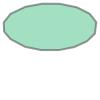

In [18]:
#display(buffer)
display(hasInfo(buffer,'sum(precipitation_amount PT1H)'))
#bla = [b['geometry']['coordinates'] for b in allCoordinates if 'geometry' in b.keys()]
#display(sum([Point(b).within(buffer) for b in bla]))

In [ ]:
humStations = hasInfo('mean(relative_humidity PT1H)')
varStations['humidity'] = sorted(humStations, key=lambda k: k['distance'])[:numStations] 

fig = gmaps.figure()
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig.add_layer(getMarkerLayer(humStations))
fig

In [ ]:
windStations = hasInfo('wind_speed')
#Getting data only for the three closest stations
varStations['wind_speed'] = sorted(windStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(windStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

In [ ]:
windDirStations = hasInfo('wind_from_direction')
varStations['wind_direction'] = sorted(windDirStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(windDirStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

In [ ]:
radStations = hasInfo('mean(surface_downwelling_shortwave_flux_in_air PT1H)')
varStations['radiation'] = sorted(radStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(radStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

In [ ]:
pressStations = hasInfo('air_pressure_at_sea_level')
varStations['air_pressure'] = sorted(pressStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(pressStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

In [ ]:
tempStations = hasInfo('air_temperature')
varStations['air_temperature'] = sorted(tempStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(tempStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

In [ ]:
cloudStations = hasInfo('cloud_area_fraction',timeResolution='PT6H')
varStations['cloud_cover'] = sorted(cloudStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(cloudStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

## Downloading data for the three nearest stations

#### Downloading data from station

In [ ]:
def getData(stations):
    data={}
    instantiated=False
    for station in stations:
        df,junk = metno.downloadData(station['id'],
                                      station['variable'],
                                      datesToGet)
        #print(df.describe())
        if instantiated is False:
            data=df
            instantiated=True
        else:
            data=pd.merge(data,df,left_index = True, right_index = True, how = 'outer')
    return data

allData = {}
for key, stations in varStations.items():
    display('Downloading {} data'.format(key))
    allData[key] = getData(stations)
    


In [ ]:
filename = 'metno.pickle'
with open(filename, 'wb') as handle:
    pickle.dump([varStations,allData], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
def plotVar(variable):
    allData[variable].plot(subplots=True,
                           figsize=(20,3*len(allData[variable].columns)),
                           marker='.',
                           markersize=1,                           
                           linestyle='None')

In [ ]:
for key in allData:
    plotVar(key)

In [ ]:
display(varStations)